To Do:
1. Invariant mass plot with data and background
2. Add higgs, signal
3. Add cross-section to all background and signal
4. Apply blinding
5. Match data and MC
6. Apply selection cuts.

In [2]:
import ROOT

In [12]:
def create_lorentz_vector(pt, eta, phi, m):
    lv = ROOT.TLorentzVector()
    lv.SetPtEtaPhiM(pt, eta, phi, m)
    return lv

def process_file(file_path, tree_name):
    # Open the ROOT file in read mode
    file_1 = ROOT.TFile(file_path, "READ")
    tree = file_1.Get(tree_name)

    # Array to store the invariant mass values
    invariant_masses = []

    if not tree:
        print(f"Tree not found in file: {file_path}")
    else:
        for event in tree:
            if not all(hasattr(event, var) for var in ["lead_pt", "lead_eta", "lead_phi", "lead_mass", "sublead_pt", "sublead_eta", "sublead_phi", "sublead_mass"]):
                print(f"Missing variables in event from file: {file_path}")
                continue


            lead_pt = event.lead_pt
            lead_eta = event.lead_eta
            lead_phi = event.lead_phi
            lead_mass = event.lead_mass
            sublead_pt = event.sublead_pt
            sublead_eta = event.sublead_eta
            sublead_phi = event.sublead_phi
            sublead_mass = event.sublead_mass

            # Create Lorentz vectors for the lead and sublead b-jets
            lv1 = create_lorentz_vector(lead_pt, lead_eta, lead_phi, lead_mass)
            lv2 = create_lorentz_vector(sublead_pt, sublead_eta, sublead_phi, sublead_mass)

            # Calculate the total Lorentz vector
            lv = lv1 + lv2

            # Get the invariant mass
            invariant_mass = lv.M()

            # Store the invariant mass
            invariant_masses.append(invariant_mass)

    # Close the ROOT file
    file_1.Close()

    # Return the invariant mass values
    return invariant_masses

In [13]:
# Data file paths
data_file_paths = [
    "../../output_root/Data_EraE.root",
    "../../output_root/Data_EraF.root",
    "../../output_root/Data_EraG.root"
]

# Process background files
background_files = [
    ("../../output_root/GGJets.root", "GGJets"),
    ("../../output_root/GJetPt20To40.root", "GJetPt20To40"),
    ("../../output_root/GJetPt40.root", "GJetPt40"),
    ("../../output_root/GluGluHToGG.root", "GluGluHToGG"),
    ("../../output_root/ttHToGG.root", "ttHToGG"),
    ("../../output_root/VBFHToGG.root", "VBFHToGG"),
    ("../../output_root/VHToGG.root", "VHToGG")
]

# Define the signal file path
signal_file = "../../output_root/GluGluToHH.root"




# Tree and variable names
tree_name = "DiphotonTree/data_125_13TeV_NOTAG"

# Branching ratio
BR_HToGG = 2.270E-03

# Cross sections for backgrounds and signal
cross_sections = {
    "GGJets": 88.75,
    "GJetPt20To40": 242.5,
    "GJetPt40": 919.1,
    "GluGluHToGG": 39.91 * BR_HToGG,
    "ttHToGG": 0.0013 * BR_HToGG ,
    "VBFHToGG": 0.00926 * BR_HToGG,
    "VHToGG": 0.00545 * BR_HToGG,
    "GluGluToHH": 0.1186
}   # xs in pb 


integrated_luminosities = {
    "Data_EraE": 5.8070,
    "Data_EraF": 17.7819,
    "Data_EraG": 3.0828
}   # lumi in fb-1



In [8]:
# Total integrated luminosity
integrated_luminosity_sum = sum(integrated_luminosities.values())
total_integrated_luminosity = integrated_luminosity_sum*1000

In [9]:
# Process data files
data_invariant_masses = []
for data_file_path in data_file_paths:
    data_invariant_masses.extend(process_file(data_file_path, tree_name))


In [10]:
# Process background files and create histograms
background_hists = {}
hex_colors = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
rgb_colors = [(int(h[1:3], 16), int(h[3:5], 16), int(h[5:], 16)) for h in hex_colors]

for i, (background_file, bg_name) in enumerate(background_files):
    bg_invariant_masses = process_file(background_file, tree_name)
    bg_hist = ROOT.TH1F(f"hist_{bg_name}", f"{bg_name} Invariant Mass", 20, 80, 180)
    for mass in bg_invariant_masses:
        bg_hist.Fill(mass)
    r, g, b = rgb_colors[i]
    bg_hist.SetFillColor(ROOT.TColor.GetColor(r, g, b))
    cross_section = cross_sections[bg_name]
    integral = bg_hist.Integral()
    if integral > 0:
        bg_hist.Scale(cross_section * total_integrated_luminosity / integral)
    else:
        print(f"Warning: Histogram {bg_name} has zero entries.")
    background_hists[bg_name] = bg_hist

In [11]:
# Combine Higgs backgrounds into one
higgs_backgrounds = ["GluGluHToGG", "ttHToGG", "VBFHToGG", "VHToGG"]
combined_higgs_hist = ROOT.TH1F("hist_Higgs", "Higgs (#rightarrow #gamma#gamma) Invariant Mass", 20, 80, 180)

for bg_name in higgs_backgrounds:
    bg_hist = background_hists.get(bg_name)
    if bg_hist:
        combined_higgs_hist.Add(bg_hist)
        
        
# Scale the combined Higgs background
combined_higgs_cross_section = sum(cross_sections[bg_name] for bg_name in higgs_backgrounds)
combined_higgs_hist.Scale(combined_higgs_cross_section / combined_higgs_hist.Integral())

# Add the combined Higgs background to the legend
legend.AddEntry(combined_higgs_hist, "Higgs (#rightarrow #gamma#gamma)", "f")

# Draw the combined Higgs background
combined_higgs_hist.SetFillColor(ROOT.kCyan+1)
combined_higgs_hist.SetLineColor(ROOT.kBlack)
combined_higgs_hist.SetLineWidth(2)
combined_higgs_hist.Draw("SAME HIST")

ZeroDivisionError: float division by zero

In [ ]:
# Process signal file and create histogram
signal_invariant_masses = process_file(signal_file, tree_name)
signal_hist = ROOT.TH1F("hist_signal", "Signal Invariant Mass", 20, 80, 180)
for mass in signal_invariant_masses:
    signal_hist.Fill(mass)
signal_cross_section = cross_sections["GluGluToHH"]
signal_integral = signal_hist.Integral()
if signal_integral > 0:
    signal_hist.Scale(signal_cross_section * total_integrated_luminosity *1000)   #Scale factor is  weight*Lumi*Xsec.
else:
    print(f"Warning: Signal histogram has zero entries.")
signal_hist.SetLineColor(ROOT.kRed)
signal_hist.SetLineWidth(2)
# Scaling 50 times
signal_hist.Scale(50)
# Draw signal histogram
signal_hist.Draw("SAME HIST")

In [ ]:
# Create a canvas
canvas = ROOT.TCanvas("canvas", "Invariant Mass", 1000, 1200)

# Adjust canvas to include ratio plot
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.02)  # join pad1 and pad2
pad1.SetTopMargin(0.1)  # increase the top margin
pad1.SetTicks(1, 1)
pad1.Draw()
pad1.cd()

# Draw the background histograms
stack = ROOT.THStack("stack", " ")
for bg_name, bg_hist in background_hists.items():
    stack.Add(bg_hist)

# Draw the stack
stack.Draw("HIST")

# Create a histogram for data invariant masses
hist_data = ROOT.TH1F("hist_data", "", 20, 80, 180)
for mass in data_invariant_masses:
    hist_data.Fill(mass)

# Set y-axis minimum to 0 and draw the histograms
stack.SetMinimum(0)
max_y = max(stack.GetMaximum(), hist_data.GetMaximum())
stack.SetMaximum(max_y * 1.5)

# Remove x-axis label on the main plot
stack.GetXaxis().SetLabelSize(0)
stack.GetXaxis().SetTitleSize(0)

# Set y-axis label for the main plot
stack.GetYaxis().SetTitle("Events")
stack.GetYaxis().SetTitleSize(0.05)

stack.GetYaxis().SetTitleOffset(1.1)
stack.GetYaxis().SetLabelSize(0.03)


# Draw the stack and data histogram
stack.Draw("HIST")
hist_data.SetMarkerStyle(20)
hist_data.SetMarkerSize(1.2)
hist_data.SetMarkerColor(ROOT.kBlack)
hist_data.Draw("SAME E1")


# Draw signal histogram
signal_hist.Draw("SAME HIST")


# # Add legend
# legend = ROOT.TLegend(0.6, 0.6, 0.8, 0.8)
# legend.AddEntry(hist_data, "Data", "lep")
# for bg_name, bg_hist in background_hists.items():
#     legend.AddEntry(bg_hist, bg_name, "f")
# legend.Draw()

# Add legend
legend = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
legend.AddEntry(hist_data, "Data", "lep")
legend.AddEntry(background_hists["GGJets"], "#gamma#gamma + Jets", "f")
legend.AddEntry(background_hists["GJetPt20To40"], "#gamma + Jets (20 < p_{T} < 40)", "f")
legend.AddEntry(background_hists["GJetPt40"], "#gamma + Jets (p_{T} > 40)", "f")
legend.AddEntry(background_hists["GluGluHToGG"], "(GluGluHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["ttHToGG"], "(ttHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["VBFHToGG"], "(VBFHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["VHToGG"], "(VHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(signal_hist, "Signal(GluGluToHH) x 50", "l")
legend.Draw()

# Draw CMS text
cms_label = ROOT.TLatex()
cms_label.SetNDC()
cms_label.SetTextFont(61)
cms_label.SetTextSize(0.04)
cms_label.DrawLatex(0.1, 0.91, "CMS")

# Draw "Work in Progress"
work_label = ROOT.TLatex()
work_label.SetNDC()
work_label.SetTextFont(52)
work_label.SetTextSize(0.03)
work_label.DrawLatex(0.17, 0.91, "Work in Progress")

# Draw energy information
energy_label = ROOT.TLatex()
energy_label.SetNDC()
energy_label.SetTextFont(42)
energy_label.SetTextSize(0.03)
energy_label.DrawLatex(0.79, 0.91, "(13.6 TeV)")

# Set ticks on all sides with smaller size
stack.GetXaxis().SetTickSize(0.02)
stack.GetYaxis().SetTickSize(0.02)

# Draw ratio plot
canvas.cd()
pad2 = ROOT.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.05)
pad2.SetBottomMargin(0.3)
pad2.SetTicks(1, 1)
pad2.Draw()
pad2.cd()

# Create a histogram for the ratio
hist_ratio = hist_data.Clone("hist_ratio")
mc_hist = stack.GetStack().Last().Clone("mc_hist")

hist_ratio.Divide(mc_hist)
hist_ratio.SetMarkerStyle(20)
hist_ratio.SetMarkerSize(1.2)
hist_ratio.SetMarkerColor(ROOT.kBlack)

# Remove statistics box from the ratio plot
hist_ratio.SetStats(0)

# Increase text size for labels and titles
hist_ratio.GetXaxis().SetLabelSize(0.1)
hist_ratio.GetXaxis().SetTitleSize(0.12)
hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.12)

# Draw the ratio histogram
hist_ratio.Draw("ep")

# Add labels and title for the ratio plot
hist_ratio.GetXaxis().SetTitle("M_{bb} [GeV]")
hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.12)
hist_ratio.GetYaxis().SetTitle("Data / MC")
hist_ratio.GetYaxis().SetTitleOffset(0.25)
hist_ratio.GetYaxis().SetNdivisions(505)
hist_ratio.GetYaxis().SetTickLength(0.02)
hist_ratio.GetYaxis().CenterTitle(True)


# Set y-axis range and divisions
hist_ratio.SetMinimum(-10)
hist_ratio.SetMaximum(10)  # Adjust maximum as needed
hist_ratio.GetYaxis().SetNdivisions(505)  # Increase divisions for better visibility

# Draw horizontal lines at y=1 and y=2
line1 = ROOT.TLine(80, -1, 180, -1)
line1.SetLineStyle(2)  # Dashed line
line1.SetLineColor(ROOT.kRed)
line1.Draw()

line2 = ROOT.TLine(80, 1, 180, 1)
line2.SetLineStyle(2)  # Dashed line
line2.SetLineColor(ROOT.kRed)
line2.Draw()

# # Save the canvas as a PDF file
# canvas.Print("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/invariant_mass_plot_blinding_higgs_Addition_signal_cross_section_correction.pdf")

# Show the canvas
canvas.Draw()

# # Clear the canvas and histograms after saving the plot
# canvas.Clear()
# for bg_hist in background_hists.values():
#     bg_hist.Delete()
# hist_data.Delete()
# hist_ratio.Delete()
# mc_hist.Delete()

# Mass Blinding

In [1]:
import ROOT

def create_lorentz_vector(pt, eta, phi, m):
    lv = ROOT.TLorentzVector()
    lv.SetPtEtaPhiM(pt, eta, phi, m)
    return lv

def process_file(file_path, tree_name):
    file_1 = ROOT.TFile(file_path, "READ")
    tree = file_1.Get(tree_name)
    invariant_masses = []

    if not tree:
        print(f"Tree not found in file: {file_path}")
    else:
        for event in tree:
            if not hasattr(event, 'lead_bjet_pt') or not hasattr(event, 'lead_bjet_eta') or not hasattr(event, 'lead_bjet_phi') or not hasattr(event, 'lead_bjet_mass') or not hasattr(event, 'sublead_bjet_pt') or not hasattr(event, 'sublead_bjet_eta') or not hasattr(event, 'sublead_bjet_phi') or not hasattr(event, 'sublead_bjet_mass'):
                continue

            lead_bjet_pt = event.lead_bjet_pt
            lead_bjet_eta = event.lead_bjet_eta
            lead_bjet_phi = event.lead_bjet_phi
            lead_bjet_mass = event.lead_bjet_mass
            sublead_bjet_pt = event.sublead_bjet_pt
            sublead_bjet_eta = event.sublead_bjet_eta
            sublead_bjet_phi = event.sublead_bjet_phi
            sublead_bjet_mass = event.sublead_bjet_mass

            lv1 = create_lorentz_vector(lead_bjet_pt, lead_bjet_eta, lead_bjet_phi, lead_bjet_mass)
            lv2 = create_lorentz_vector(sublead_bjet_pt, sublead_bjet_eta, sublead_bjet_phi, sublead_bjet_mass)
            lv = lv1 + lv2
            invariant_mass = lv.M()

            invariant_masses.append(invariant_mass)

    file_1.Close()
    return invariant_masses





Welcome to JupyROOT 6.30/02


In [2]:
data_file_paths = [
    "../../output_root/Data_EraE.root",
    "../../output_root/Data_EraF.root",
    "../../output_root/Data_EraG.root"
]

background_files = [
    ("../../output_root/GGJets.root", "GGJets"),
    ("../../output_root/GJetPt20To40.root", "GJetPt20To40"),
    ("../../output_root/GJetPt40.root", "GJetPt40"),
    ("../../output_root/GluGluHToGG.root", "GluGluHToGG"),
    ("../../output_root/ttHToGG.root", "ttHToGG"),
    ("../../output_root/VBFHToGG.root", "VBFHToGG"),
    ("../../output_root/VHToGG.root", "VHToGG")
]

signal_file = "../../output_root/GluGluToHH.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG"
BR_HToGG = 2.270E-03

cross_sections = {
    "GGJets": 88.75,
    "GJetPt20To40": 242.5,
    "GJetPt40": 919.1,
    "GluGluHToGG": 39.91 * BR_HToGG,
    "ttHToGG": 0.0013 * BR_HToGG,
    "VBFHToGG": 0.00926 * BR_HToGG,
    "VHToGG": 0.00545 * BR_HToGG,
    "GluGluToHH": 0.1186
}

integrated_luminosities = {
    "Data_EraE": 5.8070,
    "Data_EraF": 17.7819,
    "Data_EraG": 3.0828
}

In [3]:
total_integrated_luminosity = sum(integrated_luminosities.values())


In [4]:

data_invariant_masses = []
for data_file_path in data_file_paths:
    data_invariant_masses.extend(process_file(data_file_path, tree_name))


In [5]:

background_hists = {}
hex_colors = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
rgb_colors = [(int(h[1:3], 16), int(h[3:5], 16), int(h[5:], 16)) for h in hex_colors]


In [6]:

for i, (background_file, bg_name) in enumerate(background_files):
    bg_invariant_masses = process_file(background_file, tree_name)
    bg_hist = ROOT.TH1F(f"hist_{bg_name}", f"{bg_name} Invariant Mass", 20, 80, 180)
    for mass in bg_invariant_masses:
        bg_hist.Fill(mass)
    r, g, b = rgb_colors[i]
    bg_hist.SetFillColor(ROOT.TColor.GetColor(r, g, b))
    cross_section = cross_sections[bg_name]
    integral = bg_hist.Integral()
    if integral > 0:
        bg_hist.Scale(cross_section * total_integrated_luminosity / integral)
    else:
        print(f"Warning: Histogram {bg_name} has zero entries.")
    background_hists[bg_name] = bg_hist




In [7]:
combined_higgs_hist = ROOT.TH1F("hist_Higgs", "Higgs (#rightarrow #gamma#gamma) Invariant Mass", 20, 80, 180)
for bg_name in ["GluGluHToGG", "ttHToGG", "VBFHToGG", "VHToGG"]:
    bg_hist = background_hists.get(bg_name)
    if bg_hist:
        combined_higgs_hist.Add(bg_hist)
combined_higgs_cross_section = sum(cross_sections[bg_name] for bg_name in ["GluGluHToGG", "ttHToGG", "VBFHToGG", "VHToGG"])
combined_higgs_hist.Scale(combined_higgs_cross_section / combined_higgs_hist.Integral())
combined_higgs_hist.SetFillColor(ROOT.kCyan + 1)
combined_higgs_hist.SetLineColor(ROOT.kBlack)
combined_higgs_hist.SetLineWidth(2)


In [8]:

signal_invariant_masses = process_file(signal_file, tree_name)
signal_hist = ROOT.TH1F("hist_signal", "Signal Invariant Mass", 20, 80, 180)
for mass in signal_invariant_masses:
    signal_hist.Fill(mass)
signal_cross_section = cross_sections["GluGluToHH"]
signal_integral = signal_hist.Integral()
if signal_integral > 0:
    signal_hist.Scale(signal_cross_section * total_integrated_luminosity / signal_integral)
else:
    print(f"Warning: Signal histogram has zero entries.")
signal_hist.SetLineColor(ROOT.kRed)
signal_hist.SetLineWidth(2)
signal_hist.Scale(100)


Info in <TCanvas::Print>: pdf file /afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/invariant_mass_plot_blinding_higgs_Addition_signal_cross_section.pdf has been created


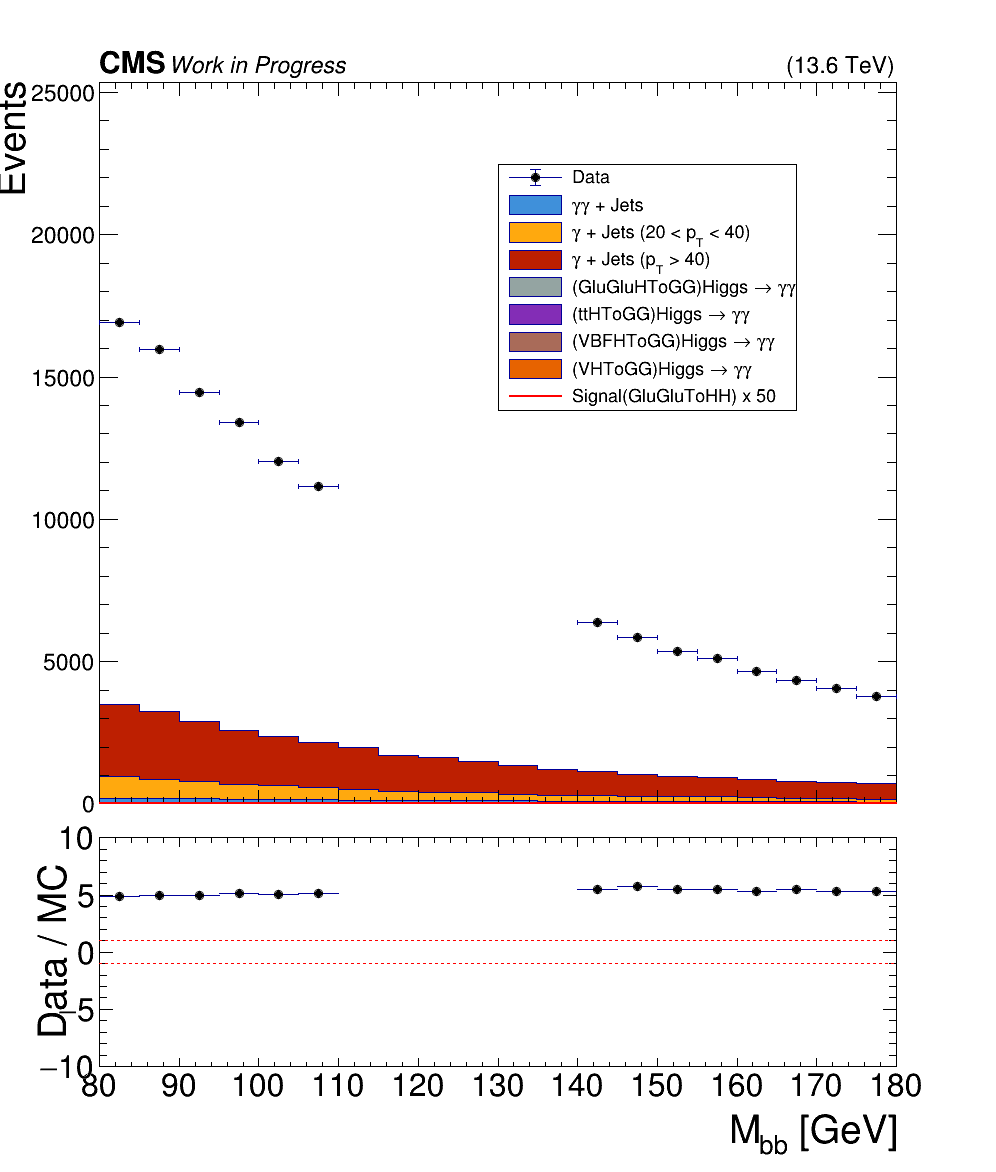

In [9]:
# Create a canvas
canvas = ROOT.TCanvas("canvas", "Invariant Mass", 1000, 1200)

# Adjust canvas to include ratio plot
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.02)  # join pad1 and pad2
pad1.SetTopMargin(0.1)  # increase the top margin
pad1.SetTicks(1, 1)
pad1.Draw()
pad1.cd()

# Draw the background histograms
stack = ROOT.THStack("stack", " ")
for bg_name, bg_hist in background_hists.items():
    stack.Add(bg_hist)

# Draw the stack
stack.Draw("HIST")

# Create a histogram for data invariant masses
hist_data = ROOT.TH1F("hist_data", "", 20, 80, 180)
for mass in data_invariant_masses:
    if not (110 <= mass <= 140):  # Apply blinding
        hist_data.Fill(mass)

# Set y-axis minimum to 0 and draw the histograms
stack.SetMinimum(0)
max_y = max(stack.GetMaximum(), hist_data.GetMaximum())
stack.SetMaximum(max_y * 1.5)

# Remove x-axis label on the main plot
stack.GetXaxis().SetLabelSize(0)
stack.GetXaxis().SetTitleSize(0)

# Set y-axis label for the main plot
stack.GetYaxis().SetTitle("Events")
stack.GetYaxis().SetTitleSize(0.05)

stack.GetYaxis().SetTitleOffset(1.1)
stack.GetYaxis().SetLabelSize(0.03)


# Draw the stack and data histogram
stack.Draw("HIST")
hist_data.SetMarkerStyle(20)
hist_data.SetMarkerSize(1.2)
hist_data.SetMarkerColor(ROOT.kBlack)
hist_data.Draw("SAME E1")


# Draw signal histogram
signal_hist.Draw("SAME HIST")


# Add legend
legend = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
legend.AddEntry(hist_data, "Data", "lep")
legend.AddEntry(background_hists["GGJets"], "#gamma#gamma + Jets", "f")
legend.AddEntry(background_hists["GJetPt20To40"], "#gamma + Jets (20 < p_{T} < 40)", "f")
legend.AddEntry(background_hists["GJetPt40"], "#gamma + Jets (p_{T} > 40)", "f")
legend.AddEntry(background_hists["GluGluHToGG"], "(GluGluHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["ttHToGG"], "(ttHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["VBFHToGG"], "(VBFHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["VHToGG"], "(VHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(signal_hist, "Signal(GluGluToHH) x 50", "l")
legend.Draw()

# Draw CMS text
cms_label = ROOT.TLatex()
cms_label.SetNDC()
cms_label.SetTextFont(61)
cms_label.SetTextSize(0.04)
cms_label.DrawLatex(0.1, 0.91, "CMS")

# Draw "Work in Progress"
work_label = ROOT.TLatex()
work_label.SetNDC()
work_label.SetTextFont(52)
work_label.SetTextSize(0.03)
work_label.DrawLatex(0.17, 0.91, "Work in Progress")

# Draw energy information
energy_label = ROOT.TLatex()
energy_label.SetNDC()
energy_label.SetTextFont(42)
energy_label.SetTextSize(0.03)
energy_label.DrawLatex(0.79, 0.91, "(13.6 TeV)")

# Set ticks on all sides with smaller size
stack.GetXaxis().SetTickSize(0.02)
stack.GetYaxis().SetTickSize(0.02)

# Draw ratio plot
canvas.cd()
pad2 = ROOT.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.05)
pad2.SetBottomMargin(0.3)
pad2.SetTicks(1, 1)
pad2.Draw()
pad2.cd()

# Create a histogram for the ratio
hist_ratio = hist_data.Clone("hist_ratio")
mc_hist = stack.GetStack().Last().Clone("mc_hist")

hist_ratio.Divide(mc_hist)
hist_ratio.SetMarkerStyle(20)
hist_ratio.SetMarkerSize(1.2)
hist_ratio.SetMarkerColor(ROOT.kBlack)

# Remove statistics box from the ratio plot
hist_ratio.SetStats(0)

# Increase text size for labels and titles
hist_ratio.GetXaxis().SetLabelSize(0.1)
hist_ratio.GetXaxis().SetTitleSize(0.12)
hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.12)

# Draw the ratio histogram
hist_ratio.Draw("ep")

# Add labels and title for the ratio plot
hist_ratio.GetXaxis().SetTitle("M_{bb} [GeV]")
hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.12)
hist_ratio.GetYaxis().SetTitle("Data / MC")
hist_ratio.GetYaxis().SetTitleOffset(0.25)
hist_ratio.GetYaxis().SetNdivisions(505)
hist_ratio.GetYaxis().SetTickLength(0.02)
hist_ratio.GetYaxis().CenterTitle(True)


# Set y-axis range and divisions
hist_ratio.SetMinimum(-10)
hist_ratio.SetMaximum(10)  # Adjust maximum as needed
hist_ratio.GetYaxis().SetNdivisions(505)  # Increase divisions for better visibility

# Draw horizontal lines at y=1 and y=2
line1 = ROOT.TLine(80, -1, 180, -1)
line1.SetLineStyle(2)  # Dashed line
line1.SetLineColor(ROOT.kRed)
line1.Draw()

line2 = ROOT.TLine(80, 1, 180, 1)
line2.SetLineStyle(2)  # Dashed line
line2.SetLineColor(ROOT.kRed)
line2.Draw()

# Save the canvas as a PDF file
canvas.Print("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/invariant_mass_plot_blinding_higgs_Addition_signal_cross_section.pdf")

# Show the canvas
canvas.Draw()

